In [1]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from numba import jit

from matplotlib import rc
rc('text', usetex=True)

In [2]:
f = open('MC_parameter.dat', 'r')
temp = f.read().split("\t")
L=float(temp[0])
dx=float(temp[1])
N=int(L/dx)
batch_size = int(temp[2])
f.close()

In [3]:
print(str(dx))

0.125


In [4]:
@jit
def w_FMT():
    R = 0.5
    k=np.linspace(0,N//2,N//2+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1 #keep notebook shutup
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1;

@jit
def cal_n0(rho,w0):
    return np.fft.irfft(np.fft.rfft(rho)*w0)

@jit
def cal_n1(rho,w1):
    return np.fft.irfft(np.fft.rfft(rho)*w1)

@jit
def cal_c1_FMT(rho):
    w0,w1 = w_FMT()
    n0=cal_n0(rho,w0)
    n1=cal_n1(rho,w1)
    F0=-np.log(1-n1)
    F1=n0/(1-n1)
    return cal_n0(F0,w0)+cal_n1(F1,w1)

@jit
def cal_rho_ML(mu,c1,V):
    rho_ML = np.exp(-c1-V+mu)
    return rho_ML

In [5]:

def picard_update(rho,alpha,mu,Vext):

    c1 = cal_c1_FMT(rho)
    rho_new = cal_rho_ML(mu,c1,Vext)
    error = np.sum((rho_new-rho)**2)*dx
    rho=(1-alpha)*rho+alpha*rho_new
    return rho,error


In [11]:
f = open('MC_inform.dat', 'r')
temp = f.read().split("\t")
mu=np.log(float(temp[2]))

In [12]:
rho = np.full(N,0.1)
Vext = np.loadtxt("Vext_0.dat")
alpha=0.01
for i in range (10000):
    rho,err=picard_update(rho,alpha,mu,Vext)
    if(i%100==0):
        print(i,err)
    if(err<10**-6):
        break;

0 93.88675671286504
100 0.02895619634392538
200 0.002304450211401107
300 0.00032866745351062634
400 5.0254737384492e-05
500 8.174738926552316e-06
600 1.4184699547499258e-06


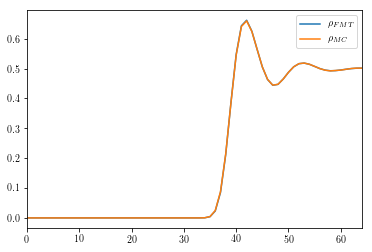

In [16]:
rho_MC = np.loadtxt("rho_0.dat")
plt.plot(rho,label=r"$\rho_{FMT}$")
plt.plot(rho_MC,label=r"$\rho_{MC}$")
plt.xlim([0,L/4/dx])
plt.legend()

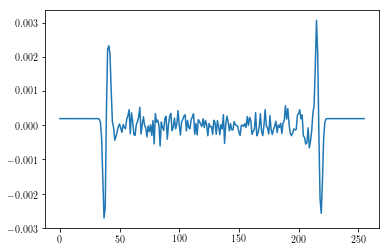

In [14]:
plt.plot(rho-rho_MC,label=r"$\Delta\rho$")